# **Mini Transformer for Dialogue Generation**

Notebook ini mengimplementasikan model Transformer Seq2Seq (encoder–decoder) untuk tugas dialog generation.  

## 1. Ringkasan Teori

Arsitektur yang digunakan adalah **Transformer Seq2Seq** (encoder–decoder) sebagaimana diperkenalkan dalam “Attention Is All You Need” (Vaswani et al., 2017).  
Model ini terdiri dari:
- **Encoder**: Mengubah input sequence (pertanyaan) menjadi representasi (embedding + positional encoding + rangkaian blok self-attention dan feed-forward).
- **Decoder**: Menghasilkan output sequence (jawaban) secara autoregresif, memanfaatkan informasi dari encoder melalui mekanisme cross-attention.

Komponen utama:
1. **Token & Positional Embedding**  
2. **Masked Multi-Head Self-Attention** (pada decoder)  
3. **Multi-Head Cross-Attention** (decoder menarik informasi dari encoder)  
4. **Feed-Forward Network**  
5. **Residual Connection + LayerNorm**  

Varian eksperimen dalam notebook ini:
- **vanilla_small** (kecil, tanpa relative positional bias)  
- **vanilla_big**  (lebih besar, tanpa relative positional bias)  
- **relpos_small** (kecil, dengan relative positional bias)  
- **relpos_big**   (lebih besar, dengan relative positional bias)  

## 2. Setup Lingkungan

Impor library dan atur seed untuk reproducibility.  
Pastikan `dialogs.txt` (berisi pasangan tanya–jawab) berada di direktori yang sama dengan notebook ini.

In [143]:
import random
import os
import re
import math

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from collections import Counter
from tqdm.auto import tqdm

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import evaluate

In [144]:
# Fungsi untuk mengatur seed secara konsisten di semua modul terkait
def set_seed(s: int = 42):
    random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)

# Fungsi untuk menyimpan checkpoint model (state_dict + konfigurasi)
def save_checkpoint(model: nn.Module, cfg: dict, save_path: str):
    """
    Menyimpan state_dict model dan konfigurasi (cfg) ke dalam satu file .pt
    """
    checkpoint = {
        'cfg': cfg,
        'state_dict': model.state_dict()
    }
    torch.save(checkpoint, save_path)

# Terapkan seed dan tentukan perangkat (CPU atau GPU)
set_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## 3. Konfigurasi Eksperimen

Tentukan hyperparameter utama, list eksperimen, dan opsi generate.

In [145]:
# Panjang sequence maksimum (token), batch size, jumlah sampel, dan lain-lain
MAX_SEQ_LEN       = 64     # panjang maksimum (dalam token) untuk src + trg
BATCH_SIZE        = 32     # ukuran batch untuk training
NUM_SAMPLES_TRAIN = 5000   # maksimum jumlah dialog untuk train
NUM_SAMPLES_TEST  = 200    # maksimum jumlah dialog untuk test
VAL_SPLIT_RATIO   = 0.2    # 20% data training dijadikan validation
LEARNING_RATE     = 1e-3   # learning rate untuk optimizer AdamW
EPOCHS            = 50     # jumlah epoch training
MAX_NEW_TOKENS    = 32     # maksimal token yang di-generate saat inference
DROPOUT_RATE      = 0.1    # dropout untuk layer-layer transformer
GENERATE_METHOD   = "sampling"  # Metode decoding: "sampling" atau "greedy"

# Definisi konfigurasi untuk masing-masing eksperimen
experiments = [
    {
        'name': 'vanilla_small',
        'num_layers': 2,
        'd_model': 64,
        'num_heads': 2,
        'd_ff': 256,
        'relpos': False
    },
    {
        'name': 'vanilla_big',
        'num_layers': 2,
        'd_model': 128,
        'num_heads': 4,
        'd_ff': 512,
        'relpos': False
    },
    {
        'name': 'relpos_small',
        'num_layers': 2,
        'd_model': 64,
        'num_heads': 2,
        'd_ff': 256,
        'relpos': True
    },
    {
        'name': 'relpos_big',
        'num_layers': 2,
        'd_model': 128,
        'num_heads': 4,
        'd_ff': 512,
        'relpos': True
    },
]


## 4. Data Loading & EDA

1. Baca berkas `dialogs.txt` yang berisi pasangan `<pertanyaan>` `\t` `<jawaban>`.  
2. Terapkan preprocessing dasar: lowercasing, menghapus non-huruf, dsb.  
3. Pisahkan data ke dalam `train_raw` dan `test_raw`.  
4. Visualisasikan distribusi panjang kalimat dan word cloud.

In [146]:
# 4.1. Fungsi preprocessing untuk input (pertanyaan)
def preprocess_src(text: str) -> str:
    text = text.lower()                                # lowercasing
    text = re.sub(r"[^a-z\s]", "", text)                # hanya huruf a-z dan spasi
    text = re.sub(r"\s+", " ", text).strip()            # rapikan spasi ganda
    return text

# 4.2. Fungsi preprocessing untuk target (jawaban)
def preprocess_trg(text: str) -> str:
    text = text.lower()
    text = re.sub(r"\d", "", text)                      # hilangkan digit
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,।]", "", text)  # hilangkan tanda baca tertentu (kecuali huruf dan spasi)
    text = text.strip()
    return text

In [147]:
# 4.3. Baca seluruh baris dari file dialogs.txt
with open('./dialogs.txt', 'r') as f:
    lines = f.read().strip().split('\n')

convs = []
for line in lines:
    parts = line.split('\t')
    if len(parts) == 2:
        q, a = parts
        q_clean = preprocess_src(q)
        a_clean = preprocess_trg(a)
        # Tambahkan token khusus <sos> dan <eos> pada jawaban
        a_clean = "<sos> " + a_clean + " <eos>"
        convs.append([q_clean, a_clean])

# Hitung total dialog, lalu bagi ke train dan test
n_total = len(convs)
n_test  = min(NUM_SAMPLES_TEST, n_total)
n_train = min(NUM_SAMPLES_TRAIN, n_total - n_test)

train_raw = convs[:n_train]
test_raw  = convs[n_train:n_train + n_test]

print(f"Total dialogs: {n_total}")
print(f"Train size   : {len(train_raw)}")
print(f"Test size    : {len(test_raw)}")


Total dialogs: 3725
Train size   : 3525
Test size    : 200


In [148]:
# 4.4. Buat DataFrame untuk eksplorasi (EDA)
df_train = pd.DataFrame(train_raw, columns=['src', 'trg'])
df_train['src_len'] = df_train['src'].apply(lambda x: len(x.split()))
df_train['trg_len'] = df_train['trg'].apply(lambda x: len(x.split()))

df_test = pd.DataFrame(test_raw, columns=['src', 'trg'])
df_test['src_len'] = df_test['src'].apply(lambda x: len(x.split()))
df_test['trg_len'] = df_test['trg'].apply(lambda x: len(x.split()))

In [149]:
# 4.5. Visualisasi: Distribusi panjang kalimat (train vs test)
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "Train: Panjang Pertanyaan (src)",
        "Train: Panjang Jawaban (trg)",
        "Test: Panjang Pertanyaan (src)",
        "Test: Panjang Jawaban (trg)"
    )
)

# Plot histogram
fig.add_trace(go.Histogram(x=df_train['src_len'], name='train_src'), row=1, col=1)
fig.add_trace(go.Histogram(x=df_train['trg_len'], name='train_trg'), row=1, col=2)
fig.add_trace(go.Histogram(x=df_test['src_len'], name='test_src'), row=2, col=1)
fig.add_trace(go.Histogram(x=df_test['trg_len'], name='test_trg'), row=2, col=2)

fig.update_layout(
    height=800,
    title_text="Distribusi Panjang Kalimat: Train vs Test",
    showlegend=False
)
fig.show()

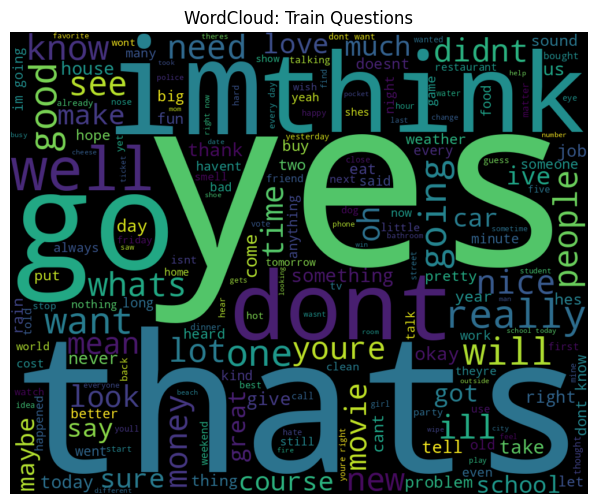

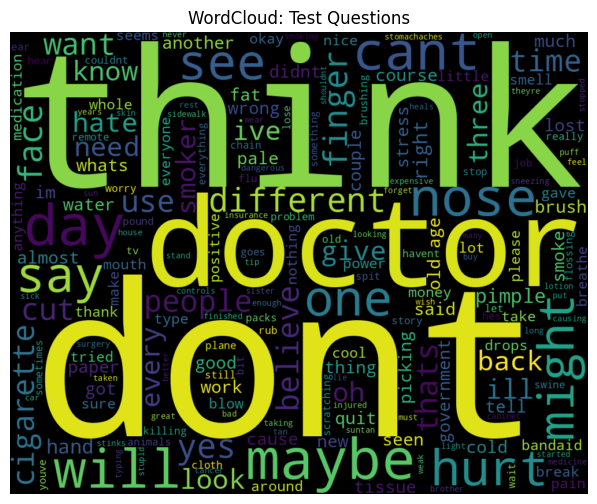

In [150]:
# 4.6. WordCloud: Kata-kata terbanyak di pertanyaan (train)
MostWordsUsed_train = WordCloud(
    background_color='black',
    width=1000,
    height=800
).generate(' '.join(df_train['src']))

plt.figure(figsize=(8,6))
plt.imshow(MostWordsUsed_train, interpolation='bilinear')
plt.title('WordCloud: Train Questions')
plt.axis('off')
plt.show()

# 4.7. WordCloud: Kata-kata terbanyak di pertanyaan (test)
MostWordsUsed_test = WordCloud(
    background_color='black',
    width=1000,
    height=800
).generate(' '.join(df_test['src']))

plt.figure(figsize=(8,6))
plt.imshow(MostWordsUsed_test, interpolation='bilinear')
plt.title('WordCloud: Test Questions')
plt.axis('off')
plt.show()

## 5. Data Preprocessing: Membangun Vocab & DialogDataset

1. Buat frequency dictionary token dari `train_raw`.  
2. Definisikan `vocab` (termasuk token khusus `<pad>`, `<bos>`, `<eos>`, `[SEP]`).  
3. Buat mapping `token2id` dan `id2token`.  
4. Implementasikan `DialogDataset` yang menghasilkan pasangan `(src, trg)` untuk training.

In [151]:
# 5.1. Hitung frekuensi setiap token (train only)
token_freq = {}
for q_clean, a_clean in train_raw:
    tokens = q_clean.split() + ["[SEP]"] + a_clean.split()
    for tok in tokens:
        token_freq[tok] = token_freq.get(tok, 0) + 1

# 5.2. Bangun vocab
# Urutan: [<pad>=0, <bos>=1, <eos>=2, [SEP]=3, token lain (urut frekuensi menurun)]
vocab = ["<pad>", "<bos>", "<eos>", "[SEP]"] + sorted(token_freq, key=token_freq.get, reverse=True)
token2id = {t: i for i, t in enumerate(vocab)}
id2token = {i: t for t, i in token2id.items()}
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size} (termasuk token khusus)")

Vocabulary size: 2447 (termasuk token khusus)


In [152]:
# 5.3. Definisi Dataset
class DialogDataset(Dataset):
    def __init__(self, dialogs, tok2id, max_len):
        """
        dialogs: list of [q_clean, a_clean]
        tok2id: mapping token ke ID
        max_len: panjang maksimum sequence (src + sep + trg), termasuk <bos> dan <eos>
        """
        self.data = []
        self.tok2id = tok2id
        for q_clean, a_clean in dialogs:
            q_toks = q_clean.split()       # list token pertanyaan
            a_toks = a_clean.split()       # list token jawaban (sudah ada <sos>, <eos>)

            # Bentuk sequence lengkap: ["<bos>"] + q_toks + ["[SEP]"] + a_toks
            seq = ["<bos>"] + q_toks + ["[SEP]"] + a_toks
            # Konversi ke ID (jika token tidak ada di vocab, gunakan "<pad>")
            ids = [tok2id.get(t, tok2id["<pad>"]) for t in seq]

            # Truncate jika lebih panjang dari max_len
            ids = ids[:max_len]
            # Padding di akhir jika terlalu pendek
            pad_len = max_len - len(ids)
            ids += [tok2id["<pad>"]] * pad_len

            # Simpan sebagai tensor
            self.data.append(torch.tensor(ids, dtype=torch.long))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        """
        Kembalikan sepasang:
        - src: semua token kecuali token terakhir
        - trg: semua token kecuali token pertama
        (shifted untuk teacher forcing)
        """
        seq = self.data[i]
        src = seq[:-1]  # (max_len - 1,)
        trg = seq[1:]   # (max_len - 1,)
        return src, trg

In [153]:
# 5.4. Buat objek dataset dan split untuk validation
full_ds = DialogDataset(train_raw, token2id, MAX_SEQ_LEN)
val_size = int(len(full_ds) * VAL_SPLIT_RATIO)
train_size = len(full_ds) - val_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

## 6. Implementasi Arsitektur Transformer (Encoder–Decoder)

Berikut komponen-komponen utama:
1. **PositionalEncoding**  
2. **MultiHeadSelfAttention** (vanilla dan relative-position)  
3. **MultiHeadCrossAttention**  
4. **FeedForward**  
5. **EncoderBlock**  
6. **DecoderBlock**  
7. **TransformerSeq2Seq** yang menggabungkan embedding, positional encoding, stack encoder, stack decoder, dan output projection.

### 6.1. Positional Encoding

In [154]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        # Buat matriks [max_len, d_model] dengan sinus dan cosinus
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()  # [max_len, 1]
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0)  # tambahkan batch dimension: [1, max_len, d_model]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [batch, seq_len, d_model]
        return x + self.pe[:, :x.size(1)].to(x.device)

### 6.2. Multi-Head Self-Attention (vanilla)

In [155]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model harus kelipatan num_heads"
        self.d_head = d_model // num_heads
        self.num_heads = num_heads
        # Proyeksi QKV sekaligus (linear ke ukuran 3*d_model)
        self.qkv = nn.Linear(d_model, 3 * d_model)
        # Proyeksi output
        self.proj = nn.Linear(d_model, d_model)
        # Dropout untuk attention weights dan output
        self.attn_drop = nn.Dropout(dropout)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        x: [batch, seq_len, d_model]
        mask (opsional): mask untuk attention (pad mask atau look-ahead mask)
        """
        B, T, D = x.shape
        # Hitung Q, K, V sekaligus dan bagi menjadi 3 bagian
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        # Ubah bentuk: [B, T, num_heads, d_head] -> [B, num_heads, T, d_head]
        q = q.view(B, T, self.num_heads, self.d_head).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.d_head).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.d_head).transpose(1, 2)

        # Hitung skor attention: (Q @ K^T) / sqrt(d_head)
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_head)  # [B, H, T, T]
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)  # [B, H, T, T]
        attn = self.attn_drop(attn)
        # Weighted sum dengan V
        out = (attn @ v).transpose(1, 2).contiguous().view(B, T, D)  # [B, T, D]
        return self.proj_drop(self.proj(out))  # [B, T, D]

### 6.3. Multi-Head Self-Attention dengan Relative Position Bias

In [156]:
class MultiHeadSelfAttentionRelPos(MultiHeadSelfAttention):
    def __init__(self, d_model: int, num_heads: int, max_len: int, dropout: float = 0.1):
        super().__init__(d_model, num_heads, dropout)
        self.max_len = max_len
        # Parameter rel_bias bentuk [num_heads, 2*max_len-1]
        self.rel_bias = nn.Parameter(torch.zeros(num_heads, 2 * max_len - 1))
        coords = torch.arange(max_len)
        rel_idx = coords[None, :] - coords[:, None] + (max_len - 1)
        # Simpan rel_idx sebagai buffer (tidak diupdate)
        self.register_buffer('rel_idx', rel_idx)  # [max_len, max_len]

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        B, T, D = x.shape
        # Hitung Q, K, V dengan shape seperti vanilla
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.view(B, T, self.num_heads, self.d_head).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.d_head).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.d_head).transpose(1, 2)

        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_head)  # [B, H, T, T]
        # Tambahkan relative-position bias
        rel_bias_T = self.rel_bias[:, self.rel_idx[:T, :T]]   # [H, T, T]
        scores = scores + rel_bias_T.unsqueeze(0)             # [B, H, T, T]

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        attn = self.attn_drop(attn)
        out = (attn @ v).transpose(1, 2).contiguous().view(B, T, D)
        return self.proj_drop(self.proj(out))

### 6.4. Multi-Head Cross-Attention (Decoder)

In [157]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model harus kelipatan num_heads"
        self.d_head = d_model // num_heads
        self.num_heads = num_heads

        # Proyeksi Q (dari decoder), serta K dan V (dari encoder)
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        self.attn_drop = nn.Dropout(dropout)

    def forward(self, x_q: torch.Tensor, x_kv: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        """
        x_q: [batch, Tq, d_model] (query dari decoder)
        x_kv: [batch, Tk, d_model] (key/value dari encoder)
        mask: mask untuk cross-attention (biasanya pad mask encoder)
        """
        B, Tq, D = x_q.shape
        _, Tk, _ = x_kv.shape

        # Proyeksi Q, K, V
        q = self.q_proj(x_q).view(B, Tq, self.num_heads, self.d_head).transpose(1, 2)  # [B, H, Tq, d_head]
        k = self.k_proj(x_kv).view(B, Tk, self.num_heads, self.d_head).transpose(1, 2) # [B, H, Tk, d_head]
        v = self.v_proj(x_kv).view(B, Tk, self.num_heads, self.d_head).transpose(1, 2) # [B, H, Tk, d_head]

        # Hitung skor attention
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.d_head)  # [B, H, Tq, Tk]
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)  # [B, H, Tq, Tk]
        attn = self.attn_drop(attn)

        out = (attn @ v).transpose(1, 2).contiguous().view(B, Tq, D)  # [B, Tq, D]
        return self.out_proj(out)  # [B, Tq, D]

### 6.5. Feed-Forward Layer

In [158]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

### 6.6. Encoder Block

In [159]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model: int, heads: int, d_ff: int, max_len: int,
                 dropout: float = 0.1, relpos: bool = False):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        # Pilih attention: vanilla atau relative-pos
        if relpos:
            self.attn = MultiHeadSelfAttentionRelPos(d_model, heads, max_len, dropout)
        else:
            self.attn = MultiHeadSelfAttention(d_model, heads, dropout)

        self.ln2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        # 1) Self-Attention + Residual
        x = x + self.attn(self.ln1(x), mask)
        # 2) Feed-Forward + Residual
        x = x + self.ff(self.ln2(x))
        return x

### 6.7. Decoder Block

In [160]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model: int, heads: int, d_ff: int, max_len: int,
                 dropout: float = 0.1, relpos: bool = False):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        if relpos:
            self.self_attn = MultiHeadSelfAttentionRelPos(d_model, heads, max_len, dropout)
        else:
            self.self_attn = MultiHeadSelfAttention(d_model, heads, dropout)

        self.ln2 = nn.LayerNorm(d_model)
        self.cross_attn = MultiHeadCrossAttention(d_model, heads, dropout)

        self.ln3 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)

    def forward(self, x: torch.Tensor,
                enc_out: torch.Tensor,
                look_ahead_mask: torch.Tensor = None,
                enc_padding_mask: torch.Tensor = None) -> torch.Tensor:
        # 1) Masked Self-Attention (decoder)
        x2 = self.self_attn(self.ln1(x), look_ahead_mask)
        x = x + x2

        # 2) Cross-Attention dengan output encoder
        x3 = self.cross_attn(self.ln2(x), enc_out, enc_padding_mask)
        x = x + x3

        # 3) Feed-Forward
        x4 = self.ff(self.ln3(x))
        x = x + x4
        return x

### 6.8. Transformer Seq2Seq (Encoder–Decoder)

In [161]:
class TransformerSeq2Seq(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()
        # Ambil konfigurasi dari dictionary
        d_model    = cfg['d_model']
        num_layers = cfg['num_layers']
        num_heads  = cfg['num_heads']
        d_ff       = cfg['d_ff']
        src_vocab  = cfg['src_vocab_size']
        trg_vocab  = cfg['trg_vocab_size']
        max_len    = cfg['max_len']
        dropout    = cfg['dropout']
        relpos     = cfg['relpos']

        # --- Encoder ---
        self.enc_embed   = nn.Embedding(src_vocab, d_model)           # embedding input
        self.enc_pos_enc = PositionalEncoding(d_model, max_len)       # positional encoding
        self.enc_drop    = nn.Dropout(dropout)
        # Gabungan num_layers blok EncoderBlock
        self.enc_layers  = nn.ModuleList([
            EncoderBlock(d_model, num_heads, d_ff, max_len, dropout, relpos)
            for _ in range(num_layers)
        ])

        # --- Decoder ---
        self.dec_embed   = nn.Embedding(trg_vocab, d_model)           # embedding target
        self.dec_pos_enc = PositionalEncoding(d_model, max_len)       # positional encoding
        self.dec_drop    = nn.Dropout(dropout)
        self.dec_layers  = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, max_len, dropout, relpos)
            for _ in range(num_layers)
        ])

        # LayerNorm akhir dan Linear untuk mapping ke vocab size
        self.ln_f = nn.LayerNorm(d_model)
        self.out  = nn.Linear(d_model, trg_vocab)

    def padding_mask(self, seq: torch.Tensor) -> torch.Tensor:
        """
        Buat pad mask (1 untuk non-pad, 0 untuk token <pad>)
        seq: [batch, seq_len]
        Hasil mask: [batch, 1, 1, seq_len] (sesuai kebutuhan attn.masked_fill)
        """
        return (seq != token2id["<pad>"]).unsqueeze(1).unsqueeze(2).float()

    def look_ahead_mask(self, size: int) -> torch.Tensor:
        """
        Buat lower-triangular matrix (look-ahead mask) ukuran [size, size], 
        digunakan untuk memastikan decoder tidak melihat future token.
        """
        mask = torch.tril(torch.ones(size, size, device=next(self.parameters()).device))
        return mask.unsqueeze(0).unsqueeze(1)  # [1, 1, size, size]

    def create_masks(self, src: torch.Tensor, trg: torch.Tensor):
        """
        Buat dua jenis mask:
        1) enc_padding_mask: untuk cross-attention di decoder (pad mask encoder)
        2) combined_mask: gabungan look-ahead mask + pad mask pada target untuk masked self-attn
        """
        # 1) Pad mask untuk src (encoder)
        enc_padding_mask = self.padding_mask(src)  # [batch, 1, 1, src_len]

        # 2) Look-ahead + pad mask untuk trg (decoder)
        look_ahead = self.look_ahead_mask(trg.size(1)).to(trg.device)  # [1,1,trg_len,trg_len]
        dec_trg_pad = self.padding_mask(trg)                             # [batch,1,1,trg_len]
        combined_mask = torch.min(dec_trg_pad, look_ahead)               # [batch,1,trg_len,trg_len]

        return enc_padding_mask, combined_mask

    def encode(self, src: torch.Tensor) -> torch.Tensor:
        """
        Proses encoding: embedding -> positional -> dropout -> rangkaian blok encoder
        src: [batch, src_len]
        return: [batch, src_len, d_model]
        """
        x = self.enc_embed(src) * math.sqrt(self.enc_embed.embedding_dim)  # scaling embedding
        x = self.enc_pos_enc(x)
        x = self.enc_drop(x)
        for layer in self.enc_layers:
            x = layer(x, None)
        return x

    def decode(self, trg: torch.Tensor, enc_out: torch.Tensor,
               combined_mask: torch.Tensor, enc_padding_mask: torch.Tensor) -> torch.Tensor:
        """
        Proses decoding: embedding -> positional -> dropout -> rangkaian blok decoder
        trg: [batch, trg_len]
        enc_out: [batch, src_len, d_model]
        combined_mask: look-ahead + pad mask [batch,1,trg_len,trg_len]
        enc_padding_mask: pad mask encoder [batch,1,1,src_len]
        return: [batch, trg_len, d_model]
        """
        x = self.dec_embed(trg) * math.sqrt(self.dec_embed.embedding_dim)
        x = self.dec_pos_enc(x)
        x = self.dec_drop(x)
        for layer in self.dec_layers:
            x = layer(x, enc_out, look_ahead_mask=combined_mask, enc_padding_mask=enc_padding_mask)
        return x

    def forward(self, src: torch.Tensor, trg: torch.Tensor) -> torch.Tensor:
        """
        Langkah forward pass penuh (untuk training):
        1) buat mask
        2) encode src
        3) decode trg (teacher forcing)
        4) output logits
        src: [batch, src_len]
        trg: [batch, trg_len] (sudah termasuk <bos>…<eos>)
        return: logits [batch, trg_len, trg_vocab]
        """
        enc_padding_mask, combined_mask = self.create_masks(src, trg)
        enc_out = self.encode(src)                              # [batch, src_len, d_model]
        dec_out = self.decode(trg, enc_out, combined_mask, enc_padding_mask)  # [batch, trg_len, d_model]
        x = self.ln_f(dec_out)
        return self.out(x)

## 7. Fungsi Greedy dan Sampling Generate (Inference)

Dua metode decoding untuk menghasilkan jawaban dari model terlatih:
1. **greedy_generate**: pilih token dengan probabilitas tertinggi di setiap langkah  
2. **sampling_generate**: sampling dari distribusi probabilitas dengan temperature dan top-k


In [162]:
# 7.1. Fungsi load_best_model: Memuat model dari checkpoint
def load_best_model(checkpoint_path: str, DEVICE: torch.device):
    """
    Memuat checkpoint (cfg + state_dict) dan restore ke model TransformerSeq2Seq.
    """
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    best_cfg = checkpoint['cfg']
    model = TransformerSeq2Seq(best_cfg).to(DEVICE)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model, best_cfg

# 7.2. Greedy Generate (inference)
def greedy_generate(model: TransformerSeq2Seq, src: torch.Tensor,
                    token2id: dict, max_new: int = 32) -> torch.Tensor:
    """
    src: [src_len] (tensor 1D), belum termasuk batch dimension
    Output: [seq_generated] (tensor 1D, termasuk <bos>…<eos>)
    """
    model.eval()
    src = src.unsqueeze(0)  # ubah jadi [1, src_len] untuk batch
    enc_out = model.encode(src)  # [1, src_len, d_model]

    # Mulai decoding dengan token <bos>
    out = torch.tensor([[token2id["<bos>"]]], device=DEVICE)  # [1,1]

    for _ in range(max_new):
        enc_padding_mask, combined_mask = model.create_masks(src, out)
        dec_out = model.decode(out, enc_out, combined_mask, enc_padding_mask)  # [1, seq_len, d_model]
        logits = model.out(model.ln_f(dec_out))[:, -1, :]  # [1, vocab_size]
        next_id = logits.argmax(dim=-1).unsqueeze(0)       # [1,1]
        out = torch.cat([out, next_id], dim=1)             # Tambahkan token baru
        if next_id.item() == token2id["<eos>"]:
            break
    return out.squeeze(0)  # [seq_len_generated]

# 7.3. Sampling Generate (Top-K + Temperature)
def sampling_generate(model: TransformerSeq2Seq, src: torch.Tensor,
                      token2id: dict, max_new: int = 32,
                      temperature: float = 1.8, top_k: int = 50) -> torch.Tensor:
    """
    src: [src_len] (tensor 1D)
    temperature: nilai suhu, misalnya 1.8 atau 1.0
    top_k: jumlah token teratas yang diizinkan sampling
    Output: [seq_generated] (tensor 1D)
    """
    model.eval()
    src = src.unsqueeze(0)
    enc_out = model.encode(src)

    out = torch.tensor([[token2id["<bos>"]]], device=DEVICE)  # [1,1]
    for _ in range(max_new):
        enc_padding_mask, combined_mask = model.create_masks(src, out)
        dec_out = model.decode(out, enc_out, combined_mask, enc_padding_mask)  # [1, seq_len, d_model]
        logits = model.out(model.ln_f(dec_out))[:, -1, :].squeeze(0)  # [vocab_size]
        logits = logits / temperature

        # Jika top_k diaktifkan, set semua elemen di luar top_k menjadi -inf
        if top_k is not None and top_k > 0:
            vals, inds = torch.topk(logits, top_k)
            mask = torch.full_like(logits, float('-inf'))
            mask.scatter_(0, inds, vals)
            logits = mask

        probs = torch.softmax(logits, dim=-1)  # distribusi probabilitas
        next_id = torch.multinomial(probs, num_samples=1).unsqueeze(0)  # [1,1]
        out = torch.cat([out, next_id], dim=1)
        if next_id.item() == token2id["<eos>"]:
            break
    return out.squeeze(0)

## 8. Training & Validasi

Langkah-langkah:
1. Loop melalui masing-masing eksperimen (vanilla_small, vanilla_big, relpos_small, relpos_big)  
2. Buat model sesuai konfigurasi, optimizer, dan loss function (CrossEntropyLoss dengan ignore_index untuk `<pad>`).  
3. Training selama `EPOCHS` epoch, simpan checkpoint jika validasi loss membaik.  
4. Catat train_losses dan val_losses untuk visualisasi di langkah berikutnya.


In [163]:
# Persiapan metric evaluation (ROUGE, BLEU, METEOR) untuk later (inference)
rouge  = evaluate.load("rouge")
bleu   = evaluate.load("bleu")
meteor = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /home/xmriz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/xmriz/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/xmriz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [164]:
train_losses, val_losses = {}, {}
global_best_val_loss = float('inf')
global_best_cfg = None
global_best_ckpt_path = None

for cfg in experiments:
    print(f"\n>>> Training eksperimen: {cfg['name']}")
    # Gabungkan cfg eksperimen dengan parameter tambahan
    full_cfg = {
        'num_layers':     cfg['num_layers'],
        'd_model':        cfg['d_model'],
        'num_heads':      cfg['num_heads'],
        'd_ff':           cfg['d_ff'],
        'src_vocab_size': vocab_size,
        'trg_vocab_size': vocab_size,
        'max_len':        MAX_SEQ_LEN,
        'dropout':        DROPOUT_RATE,
        'relpos':         cfg['relpos']
    }
    model = TransformerSeq2Seq(full_cfg).to(DEVICE)

    # Hitung jumlah parameter yang dapat dilatih
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params:,}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=token2id["<pad>"])

    tl, vl = [], []
    best_val_loss_exp = float('inf')
    best_epoch = -1

    for epoch in range(1, EPOCHS + 1):
        # ------- Training -------
        model.train()
        total_train, n_train = 0.0, 0
        for src_batch, trg_batch in train_loader:
            src_batch = src_batch.to(DEVICE)         # [B, src_len]
            trg_batch = trg_batch.to(DEVICE)         # [B, trg_len]

            optimizer.zero_grad()
            # Forward: target shifted satu langkah (teacher forcing)
            preds = model(src_batch, trg_batch[:, :-1])  # output shape: [B, trg_len-1, vocab_size]
            # Hitung loss: pred vs target[:,1:] (abaikan token <pad>)
            loss = criterion(preds.reshape(-1, vocab_size), trg_batch[:, 1:].reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_train += loss.item()
            n_train += 1

        avg_train_loss = total_train / n_train
        tl.append(avg_train_loss)

        # ------- Validasi -------
        model.eval()
        total_val, n_val = 0.0, 0
        with torch.no_grad():
            for src_batch, trg_batch in val_loader:
                src_batch = src_batch.to(DEVICE)
                trg_batch = trg_batch.to(DEVICE)
                preds = model(src_batch, trg_batch[:, :-1])
                loss = criterion(preds.reshape(-1, vocab_size), trg_batch[:, 1:].reshape(-1))
                total_val += loss.item()
                n_val += 1

        avg_val_loss = total_val / n_val
        vl.append(avg_val_loss)

        print(f" Epoch {epoch:02d}  | train_loss = {avg_train_loss:.4f}  | val_loss = {avg_val_loss:.4f}")

        # Simpan checkpoint jika validasi loss bertambah baik
        if avg_val_loss < best_val_loss_exp:
            best_val_loss_exp = avg_val_loss
            best_epoch = epoch
            ckpt_path = os.path.join("./checkpoints", f"{cfg['name']}_best.pt")
            os.makedirs("./checkpoints", exist_ok=True)
            save_checkpoint(model, full_cfg, ckpt_path)

    # Catat hasil train/val loss per eksperimen
    train_losses[cfg['name']] = tl
    val_losses[cfg['name']]   = vl

    print(f" >> Best val loss untuk {cfg['name']}: {best_val_loss_exp:.4f} (epoch {best_epoch})")
    if best_val_loss_exp < global_best_val_loss:
        global_best_val_loss = best_val_loss_exp
        global_best_cfg = full_cfg
        global_best_ckpt_path = ckpt_path


>>> Training eksperimen: vanilla_small
Total trainable parameters: 705,871
 Epoch 01  | train_loss = 6.1061  | val_loss = 5.3006
 Epoch 02  | train_loss = 5.1151  | val_loss = 4.9301
 Epoch 03  | train_loss = 4.7809  | val_loss = 4.6632
 Epoch 04  | train_loss = 4.4892  | val_loss = 4.4384
 Epoch 05  | train_loss = 4.2226  | val_loss = 4.2501
 Epoch 06  | train_loss = 3.9826  | val_loss = 4.0884
 Epoch 07  | train_loss = 3.7662  | val_loss = 3.9320
 Epoch 08  | train_loss = 3.5644  | val_loss = 3.8082
 Epoch 09  | train_loss = 3.3788  | val_loss = 3.6834
 Epoch 10  | train_loss = 3.2085  | val_loss = 3.5932
 Epoch 11  | train_loss = 3.0502  | val_loss = 3.4983
 Epoch 12  | train_loss = 2.9090  | val_loss = 3.3969
 Epoch 13  | train_loss = 2.7637  | val_loss = 3.3250
 Epoch 14  | train_loss = 2.6317  | val_loss = 3.2496
 Epoch 15  | train_loss = 2.5189  | val_loss = 3.1844
 Epoch 16  | train_loss = 2.4124  | val_loss = 3.1429
 Epoch 17  | train_loss = 2.2926  | val_loss = 3.0794
 Epoch

## 9. Visualisasi Loss Curves

Tampilkan grafik train_loss dan val_loss untuk setiap eksperimen dalam satu plot 2×2.


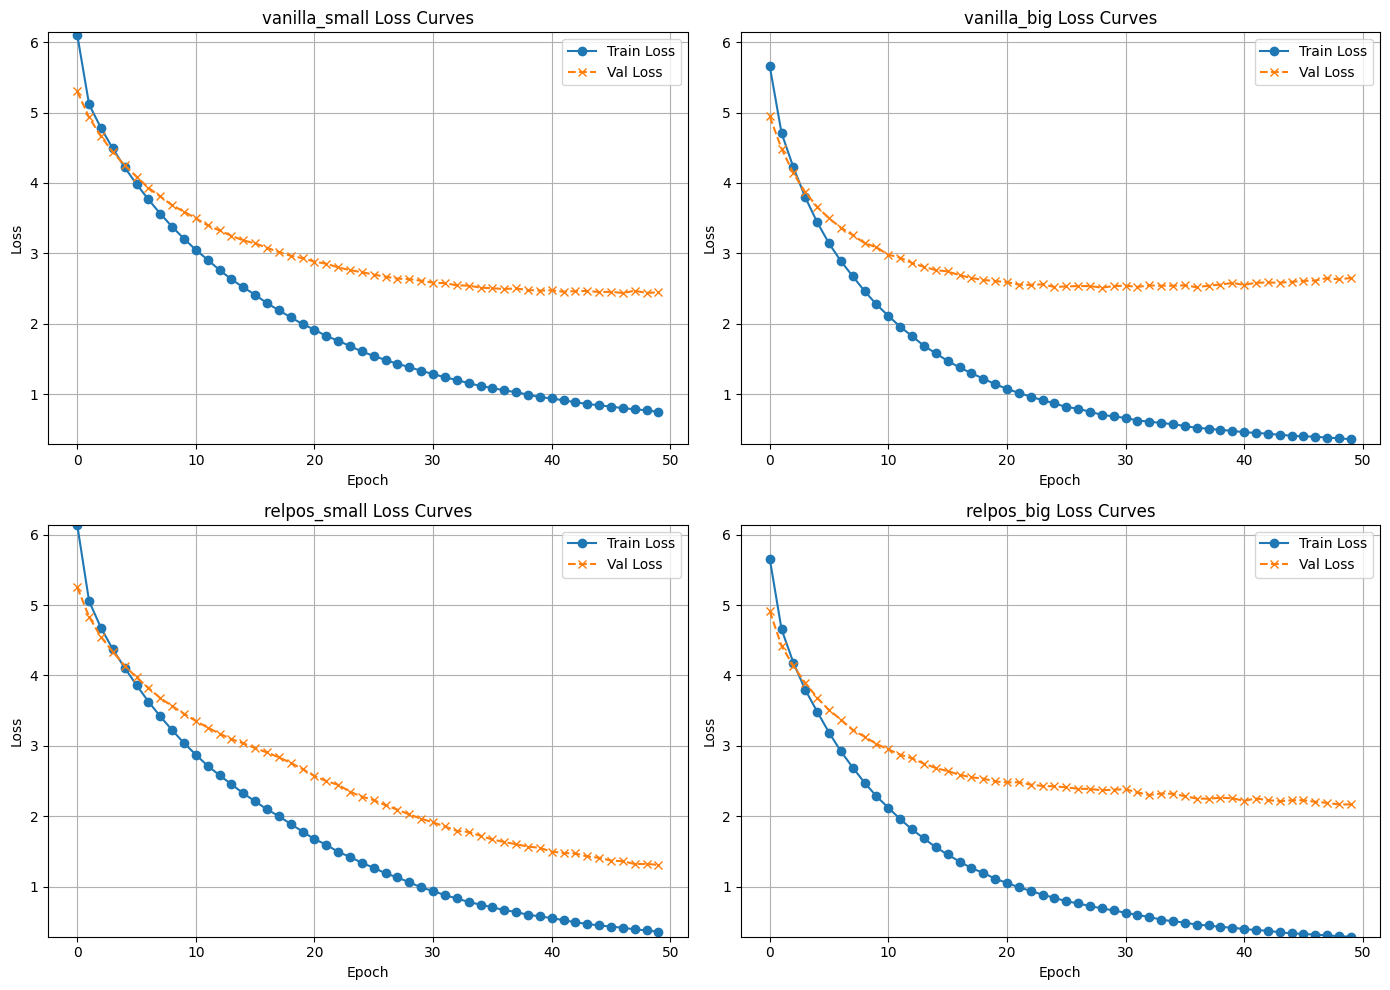

In [165]:
# Gabungkan semua nilai loss untuk menentukan y-axis range yang seragam
all_values = []
for name in train_losses:
    all_values += train_losses[name]
    all_values += val_losses[name]
global_min = min(all_values)
global_max = max(all_values)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, name in enumerate(train_losses):
    ax = axes[idx]
    ax.plot(train_losses[name], marker='o', linestyle='-', label='Train Loss')
    ax.plot(val_losses[name], marker='x', linestyle='--', label='Val Loss')
    ax.set_title(f"{name} Loss Curves")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_ylim(global_min, global_max)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## 10. Summary Model Terbaik

Cetak tabel perbandingan best validation loss setiap eksperimen, lalu tampilkan eksperimen terbaik secara global.


In [166]:
print("=== Perbandingan Best Val Loss Setiap Eksperimen ===")
df_rank = pd.DataFrame({
    'Experiment': list(val_losses.keys()),
    'BestValLoss': [min(val_losses[name]) for name in val_losses]
})
df_rank = df_rank.sort_values('BestValLoss').reset_index(drop=True)
print(df_rank.to_string(index=False))
print(f"\n>>> Model terbaik secara global: {df_rank.loc[0, 'Experiment']}")
print(f">>> Best Val Loss: {df_rank.loc[0, 'BestValLoss']:.4f}")
print(f">>> Checkpoint model terbaik berada di: {global_best_ckpt_path}")

=== Perbandingan Best Val Loss Setiap Eksperimen ===
   Experiment  BestValLoss
 relpos_small     1.310935
   relpos_big     2.168254
vanilla_small     2.438808
  vanilla_big     2.513762

>>> Model terbaik secara global: relpos_small
>>> Best Val Loss: 1.3109
>>> Checkpoint model terbaik berada di: ./checkpoints/relpos_small_best.pt


## 11. Inference & Evaluasi dengan Model Terbaik

Langkah:
1. Muat model terbaik.  
2. Untuk setiap dialog di `test_raw`, lakukan inference (sampling atau greedy).  
3. Konversi ID ke token, buang `<bos>`, `<pad>`, `<sos>`, dan berhenti saat `<eos>`.  
4. Hitung metrik ROUGE, BLEU, METEOR.  
5. Tampilkan beberapa contoh hasil prediksi.


In [167]:
# 11.1. Muat model terbaik
best_model, best_cfg = load_best_model(global_best_ckpt_path, DEVICE)
print(f">>> Loaded best model config: {best_cfg}")

>>> Loaded best model config: {'num_layers': 2, 'd_model': 64, 'num_heads': 2, 'd_ff': 256, 'src_vocab_size': 2447, 'trg_vocab_size': 2447, 'max_len': 64, 'dropout': 0.1, 'relpos': True}


In [168]:
# 11.2. Proses inference
preds, refs = [], []
for q_clean, a_clean in test_raw:
    # a_clean: "<sos> ... <eos>"
    # 1) Tokenisasi pertanyaan
    q_toks = q_clean.split()

    # 2) Jika panjang q_toks terlalu panjang, truncasi agar masih menyisakan ruang untuk "<bos>" dan "[SEP]"
    max_q_len = MAX_SEQ_LEN - 2  # sisakan ruang minimal 2 token
    if len(q_toks) > max_q_len:
        q_toks = q_toks[:max_q_len]

    # 3) Bentuk sequence input: ["<bos>"] + q_toks + ["[SEP]"]
    seq = ["<bos>"] + q_toks + ["[SEP]"]

    # 4) Konversi ke ID + pad hingga MAX_SEQ_LEN
    src_ids = [token2id.get(tok, token2id["<pad>"]) for tok in seq]
    pad_len = MAX_SEQ_LEN - len(src_ids)
    src_ids += [token2id["<pad>"]] * pad_len
    src_tensor = torch.tensor(src_ids, dtype=torch.long).to(DEVICE)

    # 5) Generate dengan metode yang dipilih
    if GENERATE_METHOD == "greedy":
        out_ids = greedy_generate(best_model, src_tensor, token2id, max_new=MAX_NEW_TOKENS)
    else:
        out_ids = sampling_generate(best_model, src_tensor, token2id,
                                    max_new=MAX_NEW_TOKENS, temperature=1.8, top_k=50)

    # 6) Konversi ID ke token, berhenti saat "<eos>"
    tokens = [id2token[idx.item()] for idx in out_ids]
    gen_tokens = []
    for tok in tokens:
        if tok in ("<bos>", "<pad>"):
            continue
        if tok == "<eos>":
            break
        # Abaikan "<sos>" jika muncul
        if tok == "<sos>":
            continue
        gen_tokens.append(tok)
    pred_sentence = " ".join(gen_tokens).replace("[SEP]", " ").strip()
    preds.append(pred_sentence)

    # 7) Reference: buang "<sos>" dan "<eos>" dari a_clean
    refs.append(a_clean.replace("<sos> ", "").replace(" <eos>", "").strip())

In [169]:
# 11.3. Hitung metrik
rouge_res  = rouge.compute(predictions=preds, references=refs)
bleu_res   = bleu.compute(predictions=preds, references=[[r] for r in refs])
meteor_res = meteor.compute(predictions=preds, references=refs)

metrics = {
    "Metric": [
        "ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum",
        "BLEU", "BLEU_bp", "METEOR"
    ],
    "Score": [
        rouge_res['rouge1'],
        rouge_res['rouge2'],
        rouge_res['rougeL'],
        rouge_res['rougeLsum'],
        bleu_res['bleu'],
        bleu_res['brevity_penalty'],
        meteor_res['meteor']
    ]
}

df_metrics = pd.DataFrame(metrics)
df_metrics["Score"] = df_metrics["Score"].map(lambda x: f"{x:.4f}")
display(df_metrics.style.set_table_styles([
    {"selector": "th", "props": [("text-align","left")]},
    {"selector": "td", "props": [("text-align","right")]},
    {"selector": "table", "props": [("width","50%"), ("margin","0 auto")]}
]))

,Metric,Score
0,ROUGE-1,0.0368
1,ROUGE-2,0.0028
2,ROUGE-L,0.0365
3,ROUGE-Lsum,0.0362
4,BLEU,0.0000
5,BLEU_bp,0.6353
6,METEOR,0.0243


## 12. Tampilkan Contoh Hasil Prediksi

Tampilkan 20 contoh dialog (pertanyaan, jawaban asli, prediksi).


In [170]:
# 12.1. Ambil 20 contoh pertama
examples = test_raw[:20]
refs_20   = refs[:20]
preds_20  = preds[:20]

# 12.2. Buat DataFrame agar mudah ditampilkan
df_examples = pd.DataFrame({
    "Pertanyaan":   [e[0] for e in examples],
    "Jawaban Asli": refs_20,
    "Prediksi":     preds_20
})

# 12.3. Atur style agar kolom terbaca dengan baik (wrap text)
styles = [
    {"selector": "th",    "props": [("text-align","left"), ("font-weight","bold")]},
    {"selector": "td",    "props": [("text-align","left"), ("white-space","pre-wrap")]},
    {"selector": "table", "props": [("width", "200%"), ("table-layout", "fixed")]}
]
display(df_examples.style.set_table_styles(styles).set_properties(**{
    'max-width': '400px',
    'text-overflow': 'ellipsis'
}))


,Pertanyaan,Jawaban Asli,Prediksi
0,so ill just buy another one,you can wear this one around the house,told another one another one best
1,you can wear this one around the house,next time i'll soak it immediately,one the house
2,my fingers hurt,why do they hurt,my drivers
3,why do they hurt,i type too much,about everyone isn't they tires
4,i type too much,you should take a break,i
5,you should take a break,i need to type to make money,a baseball than take everyone cost cost
6,i need to type to make money,but typing is causing you pain,you they'll to make plans
7,but typing is causing you pain,maybe i should see a doctor,you are my receipt is superbad whats next
8,maybe i should see a doctor,doctors are too expensive,maybe i should quit
9,doctors are too expensive,he might tell me to rest for a while,cars are


## 13. Ringkasan dan Kesimpulan

- Notebook ini mengimplementasikan **Transformer Seq2Seq** untuk dialog generation.  
- Terdapat empat varian eksperimen (vanilla_small, vanilla_big, relpos_small, relpos_big) dengan perbedaan penggunaan relative positional bias dan ukuran model.  
- Proses melibatkan: EDA, preprocessing, pembuatan dataset, implementasi arsitektur, training, validasi, visualisasi loss curves, serta inference & evaluasi (ROUGE, BLEU, METEOR).  
- Model terbaik disimpan sebagai checkpoint (`*.pt`) dan kemudian digunakan untuk inference pada data test.  
